In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, GRU
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
import numpy as np

In [2]:
dataset=pd.read_csv("Language Detection.csv")
dataset.head(10)

,Text,Language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
5,エノが行きがかりでバスに乗ってしまい、気分が悪くなった際に助けるが、今すぐバスを降りたいと運...,Japanese
6,tsutinalar i̇ngilizce tsuutina kanadada albert...,Turkish
7,müller mox figura centralis circulorum doctoru...,Latin
8,برقی بار electric charge تمام زیرجوہری ذرات کی...,Urdu
9,シャーリー・フィールドは、サン・ベルナルド・アベニュー沿い市民センターとrtマーティン高校に...,Japanese


In [3]:
# Block 3: Preprocess Dataset
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    return text

# Apply preprocessing
dataset.dropna(subset=['Text', 'Language'], inplace=True)
dataset.drop_duplicates(inplace=True)
dataset['Cleaned_Text'] = dataset['Text'].apply(clean_text)

# Save cleaned dataset
cleaned_file = "Lingual_data_cleaned.csv"
dataset.to_csv(cleaned_file, index=False)
print(f"Cleaned dataset saved to {cleaned_file}")

Cleaned dataset saved to Lingual_data_cleaned.csv


In [4]:
# Load the dataset
data = pd.read_csv("Lingual_data_cleaned.csv")

# Dataset Exploration
print("Dataset Overview:")
print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print("\nData Types:\n", data.dtypes)
print("\nMissing Values Per Column:\n", data.isnull().sum())
print("\nSample of Data:\n", data.head())
print("\nNumber of Duplicate Rows:", data.duplicated().sum())

Dataset Overview:
Shape: (32130, 3)
Columns: ['Text', 'Language', 'Cleaned_Text']

Data Types:
 Text            object
Language        object
Cleaned_Text    object
dtype: object

Missing Values Per Column:
 Text            0
Language        0
Cleaned_Text    4
dtype: int64

Sample of Data:
                                                 Text  Language  \
0  klement gottwaldi surnukeha palsameeriti ning ...  Estonian   
1  sebes joseph pereira thomas  på eng the jesuit...   Swedish   
2  ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...      Thai   
3  விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...     Tamil   
4  de spons behoort tot het geslacht haliclona en...     Dutch   

                                        Cleaned_Text  
0  klement gottwaldi surnukeha palsameeriti ning ...  
1  sebes joseph pereira thomas  på eng the jesuit...  
2  ถนนเจรญกรง อกษรโรมน thanon charoen krung เรมตง...  
3  வசகபபடடனம தமழசசஙகதத இநதப பததரகவசகபபடடன ஆசரயர ச...  
4  de spons behoort tot het geslach


Language Distribution Summary:
Language
English       2382
French        1997
Spanish       1812
Russian       1687
Dutch         1538
Arabic        1530
Turkish       1471
Tamil         1445
Hindi         1052
Persian       1000
Thai          1000
Japanese      1000
Urdu          1000
Chinese       1000
Korean        1000
Romanian      1000
Estonian       999
Portugese      997
Pushto         993
Swedish        992
Indonesian     975
Latin          953
Portugeese     736
Italian        694
Sweedish       673
Malayalam      591
German         465
Danish         424
Kannada        366
Greek          358
Name: count, dtype: int64


C:\Users\aksha\AppData\Local\Temp\ipykernel_27600\1479120577.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


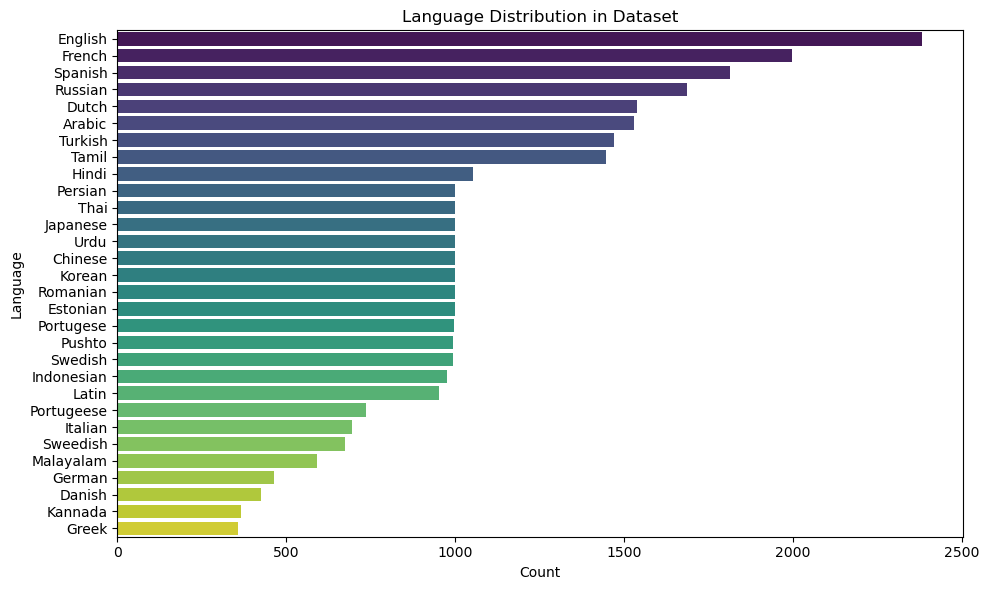

In [5]:
# Class Distribution Analysis
if "Language" in data.columns:
    print("\nLanguage Distribution Summary:")
    print(data["Language"].value_counts())

    # Visualize language distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(
        y=data["Language"].value_counts().index,
        x=data["Language"].value_counts().values,
        palette="viridis"
    )
    plt.title("Language Distribution in Dataset")
    plt.xlabel("Count")
    plt.ylabel("Language")
    plt.tight_layout()
    plt.show()

In [11]:
#  Preprocessing
# Handle missing values
data.dropna(inplace=True)

# Remove duplicates
data.drop_duplicates(inplace=True)
print("\nDuplicate Rows After Handling:", data.duplicated().sum())

# Clean text
def clean_text(text):
    text = re.sub(r'\\', '', text)       # Remove backslashes
    text = re.sub(r'\n', ' ', text)      # Replace line breaks with a space
    text = re.sub(r'\s+', ' ', text)     # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = text.strip()                   # Remove leading and trailing whitespaces
    return text

data['Cleaned_Text'] = data['Cleaned_Text'].apply(clean_text)
# Save clean dataset
data.to_csv("new_merged_dataset.csv", index=False)


Duplicate Rows After Handling: 0


In [12]:
file_path = 'new_merged_dataset.csv'
df = pd.read_csv(file_path)

word_column = 'Cleaned_Text'

df = df[df[word_column].notna() & (df[word_column] != '')]

tokenizer = Tokenizer()

tokenizer.fit_on_texts(df[word_column])

sequences = tokenizer.texts_to_sequences(df[word_column])


max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_length)


df['padded_sequences'] = list(padded_sequences)


In [13]:
# Save the updated dataset
output_path = 'final_dataset.csv'
df.to_csv(output_path, index=False)

print(f"Processed dataset saved to {output_path}")

Processed dataset saved to final_dataset.csv


In [14]:
# File path and dataset loading
dataset_path = 'Lingual_data_cleaned.csv'
data = pd.read_csv(dataset_path)

# Specify the column containing cleaned text
text_column = 'Cleaned_Text'

# Handle missing values by filling them with an empty string
data[text_column] = data[text_column].fillna('')
# Initialize CountVectorizer with a feature limit
vectorizer = CountVectorizer(max_features=10000)

# Transform the text column into feature vectors
features = vectorizer.fit_transform(data[text_column]).toarray()

# Save the vectorizer model for reuse
vectorizer_filename = 'vectorizer.pkl'
joblib.dump(vectorizer, vectorizer_filename)

print(f"Vectorizer has been saved as '{vectorizer_filename}'")


Vectorizer has been saved as 'vectorizer.pkl'


In [15]:
# Load the dataset
data_file = "Lingual_data_cleaned.csv"
dataset = pd.read_csv(data_file)

# Extract features and labels
text_data = dataset['Cleaned_Text'].astype(str).values
language_labels = dataset['Language'].values

# Encode the labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(language_labels)

# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<UNK>")  # Use "<UNK>" for unknown words
tokenizer.fit_on_texts(text_data)

# Text to sequences
text_sequences = tokenizer.texts_to_sequences(text_data)

# Padding sequences
sequence_length = 120  # Adjusted sequence length
padded_texts = pad_sequences(text_sequences, maxlen=sequence_length, padding='post', truncating='post')

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_texts, numeric_labels, test_size=0.2, random_state=42)

# Build the MLP model
mlp_model = Sequential([
    Flatten(input_shape=(sequence_length,)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
training_history = mlp_model.fit(
    X_train, y_train,
    epochs=15, 
    batch_size=64,
    validation_data=(X_test, y_test)
)

# Evaluate the model
eval_loss, eval_accuracy = mlp_model.evaluate(X_test, y_test, verbose=0)
print(f"Model Evaluation - Accuracy: {eval_accuracy:.2f}")

# Save the model
model_filename = 'MLP_NEW_model.h5'
mlp_model.save(model_filename)
print(f"Model has been saved as '{model_filename}'")

# Save the tokenizer and label encoder
tokenizer_file = 'tokenizer_mlp.pkl'
label_encoder_file = 'label_encoder_mlp.pkl'

with open(tokenizer_file, 'wb') as token_file:
    pickle.dump(tokenizer, token_file)

with open(label_encoder_file, 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)

print(f"Tokenizer saved as '{tokenizer_file}'")
print(f"Label encoder saved as '{label_encoder_file}'")

C:\Users\aksha\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0559 - loss: 364.2988 - val_accuracy: 0.0735 - val_loss: 3.3518
Epoch 2/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0743 - loss: 3.9863 - val_accuracy: 0.0735 - val_loss: 3.3223
Epoch 3/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0764 - loss: 3.5543 - val_accuracy: 0.0735 - val_loss: 3.3100
Epoch 4/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0727 - loss: 3.4455 - val_accuracy: 0.0735 - val_loss: 3.3050
Epoch 5/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0741 - loss: 3.3395 - val_accuracy: 0.0735 - val_loss: 3.3030
Epoch 6/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0746 - loss: 3.3426 - val_accuracy: 0.0735 - val_loss: 3.3021
Epoch 7/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0748 - loss: 3.3338 - val_accuracy: 0.0735 - val_loss: 3.3016
Epoch 8/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0767 - loss: 3.3391 - val_accuracy: 

Model Evaluation - Accuracy: 0.07
Model has been saved as 'MLP_NEW_model.h5'
Tokenizer saved as 'tokenizer_mlp.pkl'
Label encoder saved as 'label_encoder_mlp.pkl'


In [16]:
# Load the dataset
data_file = "Lingual_data_cleaned.csv"
dataset = pd.read_csv(data_file)

# Extract features and labels
text_data = dataset['Cleaned_Text'].astype(str).values
language_labels = dataset['Language'].values

# Encode the labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(language_labels)

# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<UNK>")  # Use "<UNK>" for unknown words
tokenizer.fit_on_texts(text_data)

# Text to sequences
text_sequences = tokenizer.texts_to_sequences(text_data)

# Padding sequences
sequence_length = 120  # Adjusted sequence length
padded_texts = pad_sequences(text_sequences, maxlen=sequence_length, padding='post', truncating='post')

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_texts, numeric_labels, test_size=0.2, random_state=42)

# Build the GRU model
gru_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=sequence_length),
    GRU(128, return_sequences=True),
    Dropout(0.3),  # Increased dropout for regularization
    GRU(64),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
gru_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
training_history = gru_model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, y_test)
)

# Evaluate the model
eval_loss, eval_accuracy = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"Model Evaluation - Accuracy: {eval_accuracy:.2f}")

# Save the model
model_filename = 'GRU_NEW_model.h5'
gru_model.save(model_filename)
print(f"Model has been saved as '{model_filename}'")

# Save the tokenizer and label encoder
tokenizer_file = 'tokenizer_gru_new.pkl'
label_encoder_file = 'label_encoder_gru_new.pkl'

with open(tokenizer_file, 'wb') as token_file:
    pickle.dump(tokenizer, token_file)

with open(label_encoder_file, 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)

print(f"Tokenizer saved as '{tokenizer_file}'")
print(f"Label encoder saved as '{label_encoder_file}'")


Epoch 1/15


C:\Users\aksha\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


402/402 ━━━━━━━━━━━━━━━━━━━━ 71s 162ms/step - accuracy: 0.0789 - loss: 3.2923 - val_accuracy: 0.1979 - val_loss: 2.7419
Epoch 2/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 71s 177ms/step - accuracy: 0.2635 - loss: 2.5702 - val_accuracy: 0.7997 - val_loss: 0.7272
Epoch 3/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 64s 160ms/step - accuracy: 0.8366 - loss: 0.6202 - val_accuracy: 0.9057 - val_loss: 0.3533
Epoch 4/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 67s 166ms/step - accuracy: 0.9197 - loss: 0.3188 - val_accuracy: 0.9105 - val_loss: 0.3220
Epoch 5/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 63s 157ms/step - accuracy: 0.9313 - loss: 0.2530 - val_accuracy: 0.9152 - val_loss: 0.2991
Epoch 6/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 62s 154ms/step - accuracy: 0.9347 - loss: 0.2221 - val_accuracy: 0.9166 - val_loss: 0.3015
Epoch 7/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 63s 157ms/step - accuracy: 0.9374 - loss: 0.1972 - val_accuracy: 0.9158 - val_loss: 0.3011
Epoch 8/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 61s 153ms/step - accuracy: 0.9399 - loss: 0.1957 - val

Model Evaluation - Accuracy: 0.92
Model has been saved as 'GRU_NEW_model.h5'
Tokenizer saved as 'tokenizer_gru_new.pkl'
Label encoder saved as 'label_encoder_gru_new.pkl'


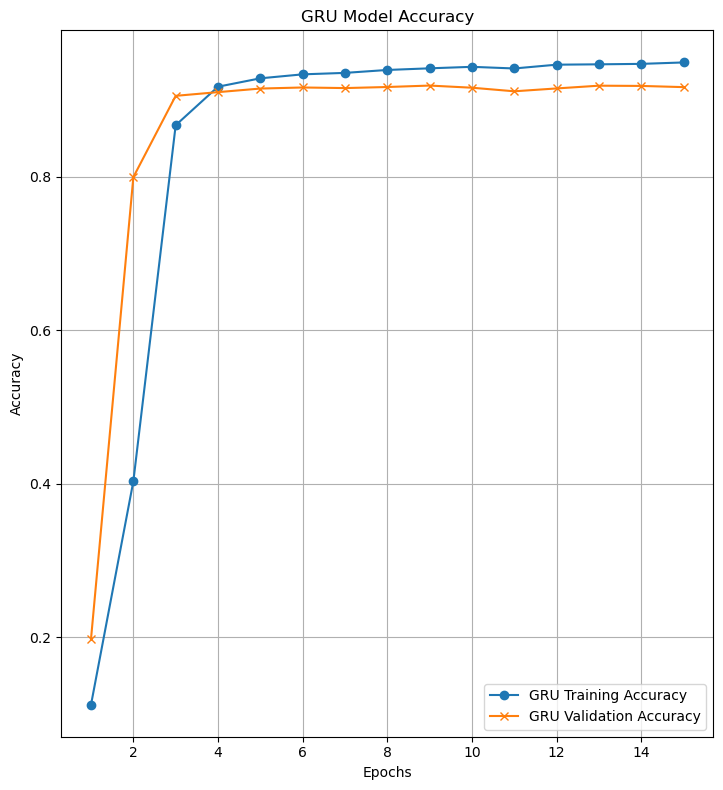

In [18]:
gru_history = training_history.history

gru_train_acc = gru_history["accuracy"]
gru_val_acc = gru_history["val_accuracy"]

# Create epochs range
epochs = range(1, len(gru_train_acc) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(14, 8))


# GRU Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, gru_train_acc, label="GRU Training Accuracy", marker='o')
plt.plot(epochs, gru_val_acc, label="GRU Validation Accuracy", marker='x')
plt.title("GRU Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()
